## Import necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Data Preprocessing

#### Load the dataset

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Desktop/PlantVillage4/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9876 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

#### Explore the dataset

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 2 12  3 14 14  5  3  3  5  7  5  6  6 11  7  7 11  8  8  6  6  7  3  9
 14 14  3  8  7 14 12  1]


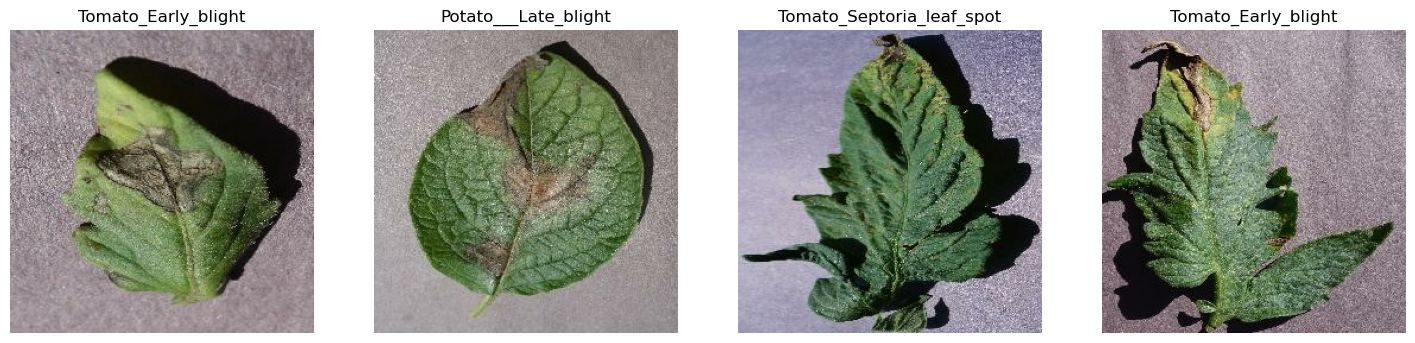

In [6]:
plt.figure(figsize=(18, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)


309

#### Split the dataset into train, validation, test sets

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

247

In [11]:
len(val_ds)

30

In [12]:
len(test_ds)

32

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

#### Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

### 1. Customized CNN model

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
input_shape

(32, 256, 256, 3)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
model.compile

<bound method Model.compile of <keras.src.engine.sequential.Sequential object at 0x000001E9AC23CF10>>

#### Train the model

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10


247/247 [==============================] - 318s 1s/step - loss: 2.3993 - accuracy: 0.1911 - val_loss: 2.5283 - val_accuracy: 0.2854
Epoch 2/10
247/247 [==============================] - 270s 1s/step - loss: 1.5574 - accuracy: 0.4698 - val_loss: 1.9144 - val_accuracy: 0.3927
Epoch 3/10
247/247 [==============================] - 277s 1s/step - loss: 1.2096 - accuracy: 0.5905 - val_loss: 1.6828 - val_accuracy: 0.4906
Epoch 4/10
247/247 [==============================] - 289s 1s/step - loss: 1.0284 - accuracy: 0.6452 - val_loss: 1.5255 - val_accuracy: 0.5333
Epoch 5/10
247/247 [==============================] - 303s 1s/step - loss: 0.8929 - accuracy: 0.6879 - val_loss: 1.0657 - val_accuracy: 0.6490
Epoch 6/10
247/247 [==============================] - 294s 1s/step - loss: 0.7808 - accuracy: 0.7240 - val_loss: 1.0268 - val_accuracy: 0.6438
Epoch 7/10
247/247 [==============================] - 295s 1s/step - loss: 0.7234 - accuracy: 0.7409 - val_loss: 0.7097 - val_accuracy: 0.75

#### Plot the Training and Validation accuracy and loss

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

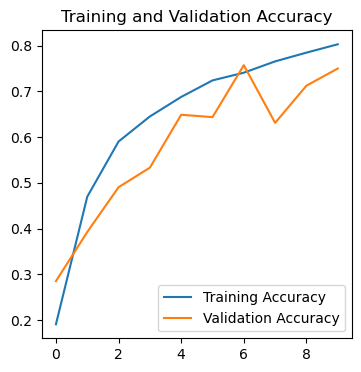

In [24]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

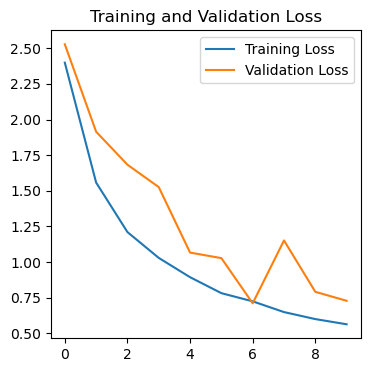

In [25]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Test the model on test set

#### Function 

In [26]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Testing

1/1 [==============================] - 0s 45ms/step


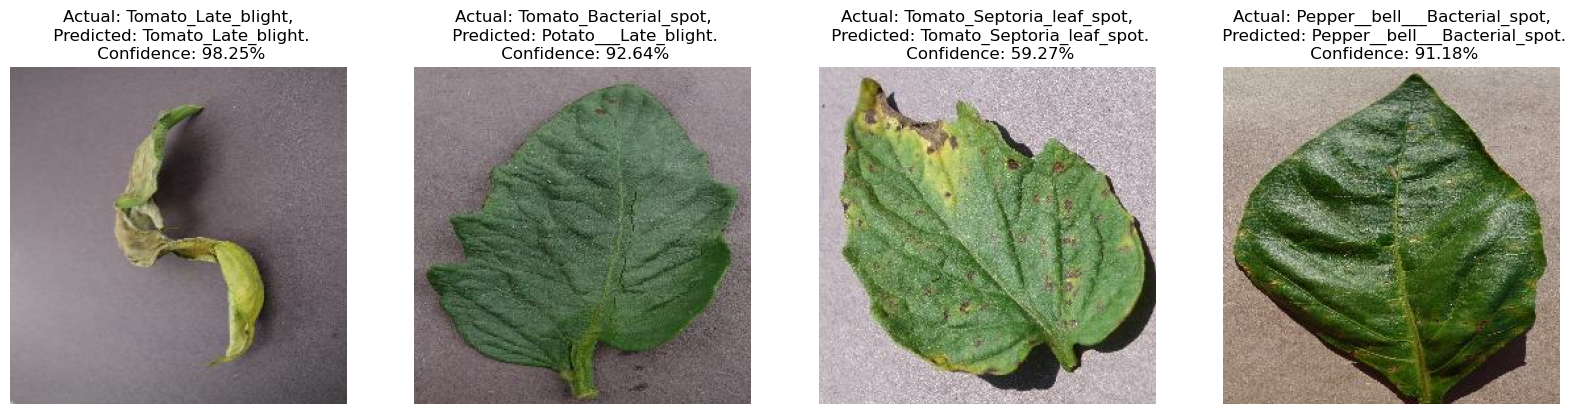

In [27]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate the model

In [28]:
model.evaluate(test_ds)

32/32 [==============================] - 10s 322ms/step - loss: 0.6695 - accuracy: 0.7734


[0.6694724559783936, 0.7734375]

### 2. ResNet50V2 Model

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model1 = models.Sequential(resize_and_rescale)
base_model1 = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape = (256,256,3),
    pooling='avg',
    classes=15,
    weights="imagenet"
)

for layer in base_model1.layers:
    layer.trainable = False
    
model1.add(base_model1)
model1.add(layers.Flatten())
model1.add(layers.Dense(128,activation='relu'))
model1.add(layers.Dense(64,activation='relu'))
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(64,activation='relu'))
model1.add(layers.Dense(n_classes, kernel_regularizer = tf.keras.regularizers.l2(0.01), activation='softmax'))

model1.build(input_shape=input_shape)

In [30]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (32, 2048)                0         
                                                                 
 dense_5 (Dense)             (32, 128)                 262272    
                                                                 
 dense_6 (Dense)             (32, 64)                  8256      
                                                                 
 dense_7 (Dense)             (32, 256)                 16640     
                                                                 
 dense_8 (Dense)             (32, 64)                 

In [31]:
model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#### Training

In [32]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10)

Epoch 1/10
247/247 [==============================] - 489s 2s/step - loss: 1.2594 - accuracy: 0.6423 - val_loss: 0.7500 - val_accuracy: 0.7833
Epoch 2/10
247/247 [==============================] - 506s 2s/step - loss: 0.6626 - accuracy: 0.8227 - val_loss: 0.6163 - val_accuracy: 0.8354
Epoch 3/10
247/247 [==============================] - 432s 2s/step - loss: 0.5370 - accuracy: 0.8530 - val_loss: 0.5220 - val_accuracy: 0.8521
Epoch 4/10
247/247 [==============================] - 431s 2s/step - loss: 0.4617 - accuracy: 0.8789 - val_loss: 0.4658 - val_accuracy: 0.8667
Epoch 5/10
247/247 [==============================] - 449s 2s/step - loss: 0.4358 - accuracy: 0.8819 - val_loss: 0.3910 - val_accuracy: 0.8896
Epoch 6/10
247/247 [==============================] - 432s 2s/step - loss: 0.3729 - accuracy: 0.8957 - val_loss: 0.4004 - val_accuracy: 0.8844
Epoch 7/10
247/247 [==============================] - 447s 2s/step - loss: 0.3561 - accuracy: 0.9005 - val_loss: 0.3823 - val_accuracy: 0.8865

#### Plot

In [33]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy of ResNet50V2')

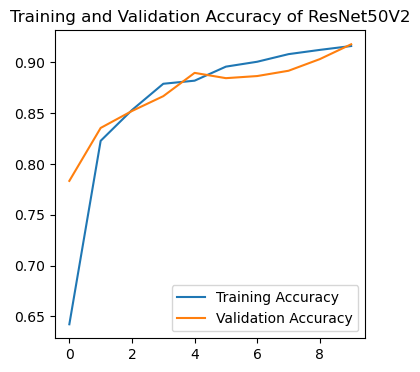

In [34]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of ResNet50V2')

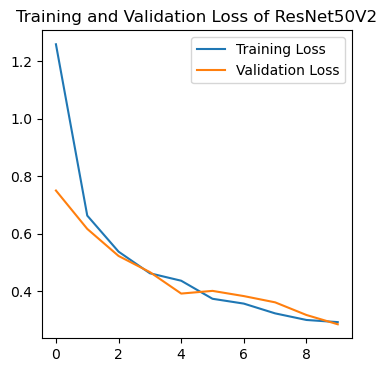

In [35]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of ResNet50V2')
plt.show()

In [39]:
model1.save("resnet_model.h5")

#### Testing

1/1 [==============================] - 0s 102ms/step


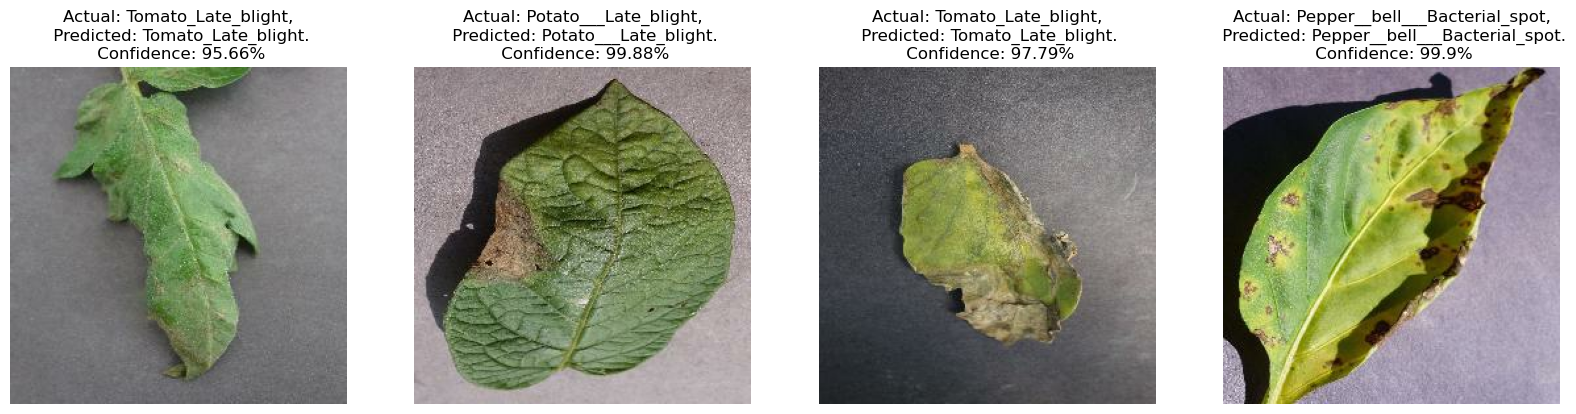

In [37]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model1, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Evaluate

In [38]:
model1.evaluate(test_ds)

32/32 [==============================] - 41s 1s/step - loss: 0.3245 - accuracy: 0.8975


[0.32445448637008667, 0.8974609375]